-------------------------------------------------------------
Reduciendo ALPHA: rho=2.23606797749979 alpha=1.1071487177940904 beta=-0.7853981633974483
Reduciendo ALPHA: rho=2.23606797749979 alpha=0.5535743588970452 beta=-1.3389725222944935
Reduciendo ALPHA: rho=2.23606797749979 alpha=0.2767871794485226 beta=-1.615759701743016
Reduciendo ALPHA: rho=2.23606797749979 alpha=0.1383935897242613 beta=-1.7541532914672775
Reduciendo ALPHA: rho=2.23606797749979 alpha=0.0691967948621306 beta=-1.823350086329408
Reduciendo ALPHA: rho=2.23606797749979 alpha=0.0345983974310653 beta=-1.8579484837604734
Reduciendo ALPHA: rho=2.23606797749979 alpha=0.01729919871553265 beta=-1.875247682476006
Reduciendo ALPHA: rho=2.23606797749979 alpha=0.008649599357766435 beta=-1.8838972818337723
Reduciendo ALPHA: rho=2.23606797749979 alpha=0.004324799678883107 beta=-1.8882220815126556
Reduciendo ALPHA: rho=2.23606797749979 alpha=0.0021623998394415533 beta=-1.8903844813520971
Reduciendo ALPHA: rho=2.23606797749979 alph

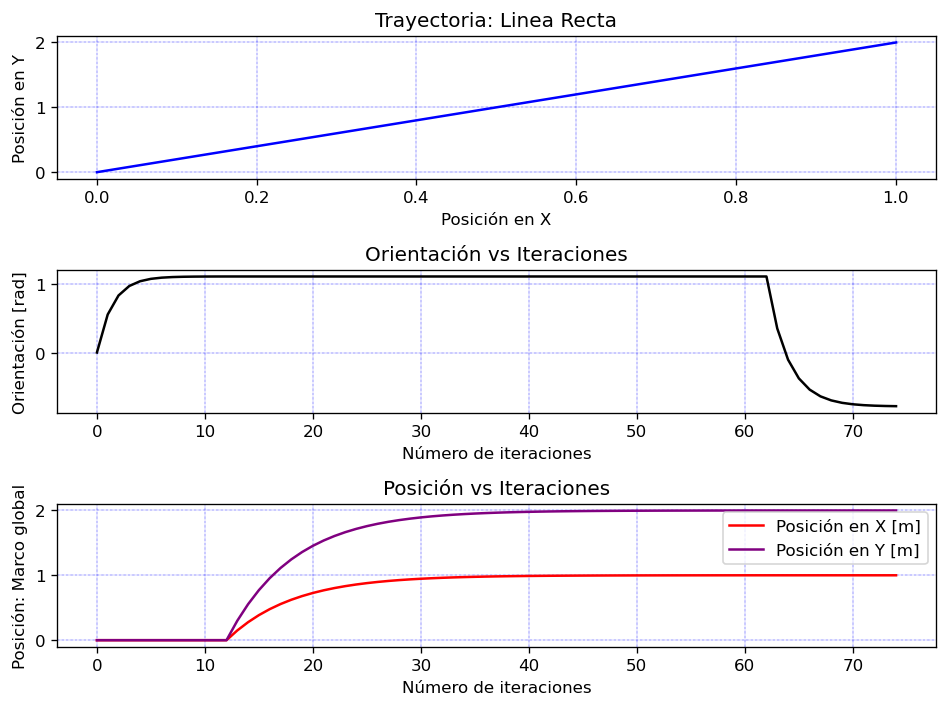

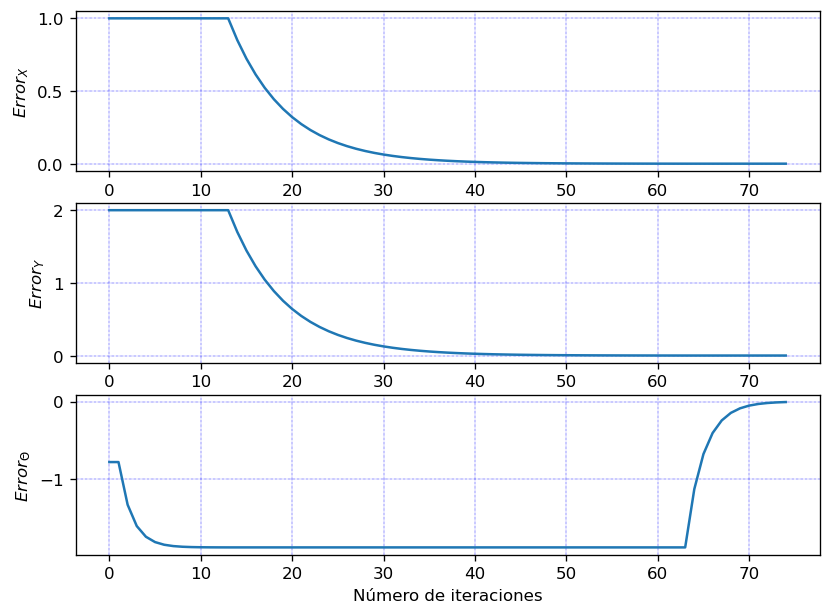

In [13]:
#!/usr/bin/env python3
from math import cos, pi, sin
import math
import sys, os
import copy 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# radio de la rueda
radii = 0.035 
# separacion entre ruedas
l = 0.23

simtime = 0
# posicion x del robot (marco global)
pos_x = 0
# posicion y del robot (marco global)
pos_y = 0
# orientacion del robot
pos_theta = None
theta = 0

# pose final deseada [x,y,theta] en marco global
endPos = [1.0, 2.0, -np.pi/4]

# variables para guardar el historial de la pose del robot de vrep
vrep_move_x = []
vrep_move_y = []
vrep_theta = []

# variables para monitorear el error de posicion en coordenadas cartesianas
errorPos_x = []
errorPos_y = [] 
errorTheta = []

# variables para graficar 
t = []
plotTime = []

# se guarda la ultima pose del robot (adquira a traves del position_callback)
vrep_move_x.append(pos_x)
vrep_move_y.append(pos_y)
vrep_theta.append(theta)

# se calcula el error de posicion con respecto a los datos de vrep
# en la practiva, los datos de vrep deben corresponder a la estimacion por odometria
errorPos_x.append(endPos[0] - vrep_move_x[-1])
errorPos_y.append(endPos[1] - vrep_move_y[-1])
errorTheta.append(endPos[2] - theta)
plotTime.append(simtime)
t.append(0)

# actualizacion de las variables de control
rho = np.sqrt(endPos[0]**2 + endPos[1]**2)
alpha = -theta + np.arctan2(endPos[1], endPos[0])
beta = errorTheta[-1]

# constantes del controlador proporcional
K_rho = 0.15 #0.25
K_alpha = 0.5 #0.5
K_beta = 0.0

#Cinematica directa
def directKinematics(vr, vl, x, y, theta):
    xresp = x + (radii/2)*(vr+vl)*cos(theta)
    yresp = y + (radii/2)*(vr+vl)*sin(theta)
    thetaresp = theta + ((radii/l)*(vr-vl))
    #print(f'theta={theta} thetaresp={thetaresp}')
    return {
        'pos_x':xresp,
        'pos_y':yresp,
        'theta':thetaresp
    }

print('-------------------------------------------------------------')
#Primero corregimos la orientacion de forma que el robot este alineado con el punto al que se quiere ir
while np.abs(alpha)>0.001:      
    # se calcula el error de posicion con respecto a los datos de vrep
    deltaX = endPos[0] - vrep_move_x[-1]
    deltaY = endPos[1] - vrep_move_y[-1]
    eTheta = endPos[2] -  vrep_theta[-1]

    # actualizacion de las variables de control
    #Si el angulo necesitado esta en el segundo o tercer cuadrante aplicar la correccion
    neededAngle= np.arctan2(deltaY, deltaX)
    if deltaY>=0 and deltaX<0:
        neededAngle+=np.pi
    elif deltaY<0 and deltaX<0:
        neededAngle-=np.pi

    rho = np.sqrt(deltaX**2 + deltaY**2)
    alpha = neededAngle-vrep_theta[-1]
    beta = eTheta

    print(f'Reduciendo ALPHA: rho={rho} alpha={alpha} beta={eTheta}')
    
    # se guarda el error de posicion
    errorPos_x.append(deltaX)
    errorPos_y.append(deltaY)
    errorTheta.append(eTheta)

    # control P para alpha -> vel angular en marco local
    velW_frameR = K_alpha*alpha
    if np.abs(velW_frameR) > np.pi:
        velW_frameR = np.pi*np.sign(velW_frameR)

    # calculo de las velocidades de las ruedas
    vr = (velW_frameR*l)/(2*radii)
    vl = (-velW_frameR*l)/(2*radii)

    #print(f'vr={vr} vl={vl}')

    # se guarda la ultima pose del robot (adquira a traves del position_callback)
    act_pos = directKinematics(vr,vl,vrep_move_x[-1],vrep_move_y[-1],vrep_theta[-1])
    vrep_move_x.append(act_pos['pos_x'])
    vrep_move_y.append(act_pos['pos_y'])
    vrep_theta.append(act_pos['theta'])
    

print('-------------------------------------------------------------')
# primero vamos a corregir el error [x,y] entre la posicion del robot
# y la posicion deseada
# para ello, rho debe aproximarse a 0.0, pero trabajaremos con una
# tolerancia de 2cm
while rho>0.001:    
    # se calcula el error de posicion con respecto a los datos de vrep
    deltaX = endPos[0] - vrep_move_x[-1]
    deltaY = endPos[1] - vrep_move_y[-1]
    eTheta = endPos[2] - vrep_theta[-1]

    # actualizacion de las variables de control
    rho = np.sqrt(deltaX**2 + deltaY**2)
    alpha = -vrep_theta[-1] + np.arctan2(deltaY, deltaX)
    beta = eTheta

    print(f'Reduciendo RHO: rho={rho} alpha={alpha} beta={eTheta}')
    
    # se guarda el error de posicion
    errorPos_x.append(deltaX)
    errorPos_y.append(deltaY)
    errorTheta.append(eTheta)

    # control P para rho -> vel lineal en x en marco local
    velX_frameR = K_rho * rho
    if np.abs(velX_frameR) > 7.0:
        velX_frameR = 7.0*np.sign(velX_frameR)

    vr = velX_frameR/radii
    vl = velX_frameR/radii

    # se guarda la ultima pose del robot (adquira a traves del position_callback)
    act_pos = directKinematics(vr,vl,vrep_move_x[-1],vrep_move_y[-1],vrep_theta[-1])
    vrep_move_x.append(act_pos['pos_x'])
    vrep_move_y.append(act_pos['pos_y'])
    vrep_theta.append(act_pos['theta'])
    
print('-------------------------------------------------------------')
# una vez le robot en la posicíon destino, se corrije la orientacion
while np.abs(beta)>0.01:
    K_beta = 0.4
    velX_frameR=0
    deltaX = endPos[0] - vrep_move_x[-1]
    deltaY = endPos[1] - vrep_move_y[-1]
    eTheta = endPos[2] - vrep_theta[-1]
    beta = eTheta

    print(f'Reduciendo BETA: rho={rho} alpha={alpha} beta={eTheta}')

    errorPos_x.append(deltaX)
    errorPos_y.append(deltaY)
    errorTheta.append(eTheta)

    # control P para beta -> vel angular en marco local
    velW_frameR = K_beta*beta
    if np.abs(velW_frameR) > np.pi:
        velW_frameR = np.pi*np.sign(velW_frameR)

    vr = (velW_frameR*l)/(2*radii)
    vl = (-velW_frameR*l)/(2*radii)

    # se guarda la ultima pose del robot (adquira a traves del position_callback)
    act_pos = directKinematics(vr,vl,vrep_move_x[-1],vrep_move_y[-1],vrep_theta[-1])
    vrep_move_x.append(act_pos['pos_x'])
    vrep_move_y.append(act_pos['pos_y'])
    vrep_theta.append(act_pos['theta'])

plotTime = list(range(0,len(errorPos_x)))
# se muestra una grafica con la trayectoria del robot
plt.figure(1, figsize=(8, 6), dpi=120)
plt.subplot(3, 1, 1)
plt.plot(np.array(vrep_move_x), np.array(vrep_move_y), c='blue')
plt.xlabel('Posición en X')
plt.ylabel('Posición en Y')
plt.title('Trayectoria: Linea Recta')
plt.grid(color='b', ls = '-.', lw = 0.25)

plt.subplot(3, 1, 2)
plt.plot(np.array(plotTime), np.array(vrep_theta), c='black')
plt.xlabel('Número de iteraciones')
plt.ylabel('Orientación [rad]')
plt.title('Orientación vs Iteraciones')
plt.grid(color='b', ls = '-.', lw = 0.25)

plt.subplot(3, 1, 3)
plt.plot(np.array(plotTime), np.array(vrep_move_x), c='red')
plt.plot(np.array(plotTime), np.array(vrep_move_y), c='purple')
plt.xlabel('Número de iteraciones')
plt.ylabel('Posición: Marco global')
plt.title('Posición vs Iteraciones')
plt.legend(['Posición en X [m]', 'Posición en Y [m]'])
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.tight_layout()
plt.savefig('Trayectoria')

# se muestra una grafica con el error en x, y y theta
plt.figure(2, figsize=(8, 6), dpi=120)
plt.subplot(3, 1, 1)
plt.plot(np.array(plotTime), np.array(errorPos_x))
plt.ylabel('$Error_{X}$')
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.subplot(3, 1, 2)
plt.plot(np.array(plotTime), np.array(errorPos_y))
plt.ylabel('$Error_{Y}$')
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.subplot(3, 1, 3)
plt.plot(np.array(plotTime), np.array(errorTheta))
plt.ylabel('$Error_{\Theta}$')
plt.xlabel('Número de iteraciones')
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.savefig('Errores')
plt.show()